## Install requirements

In [20]:
!pip install pandas numpy scikit-learn matplotlib seaborn statsmodels


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Model

Rows left: 9388
Misses in feature: 0
Misses in target: 0
MAE: 2.25

Feature importances:
                  Feature  Importance
5              race_Asian       0.326
9              race_Other       0.310
10             sex_Female       0.302
11               sex_Male       0.294
0                     age       0.292
1            priors_count       0.292
3          juv_misd_count       0.290
8    race_Native American       0.286
13      c_charge_degree_M       0.282
2           juv_fel_count       0.276
7           race_Hispanic       0.272
12      c_charge_degree_F       0.262
4   race_African-American       0.258
6          race_Caucasian       0.258


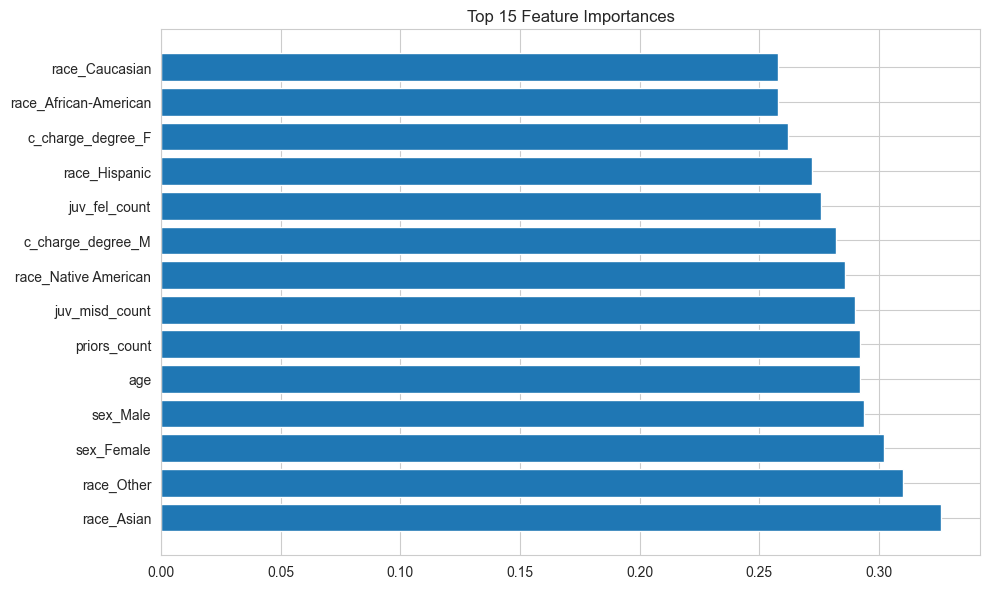


Bias analysis for races:
   Group       MAE  Avg Score  Count
0      1  2.360418   4.610648    911
1      0  2.150171   4.038513    967


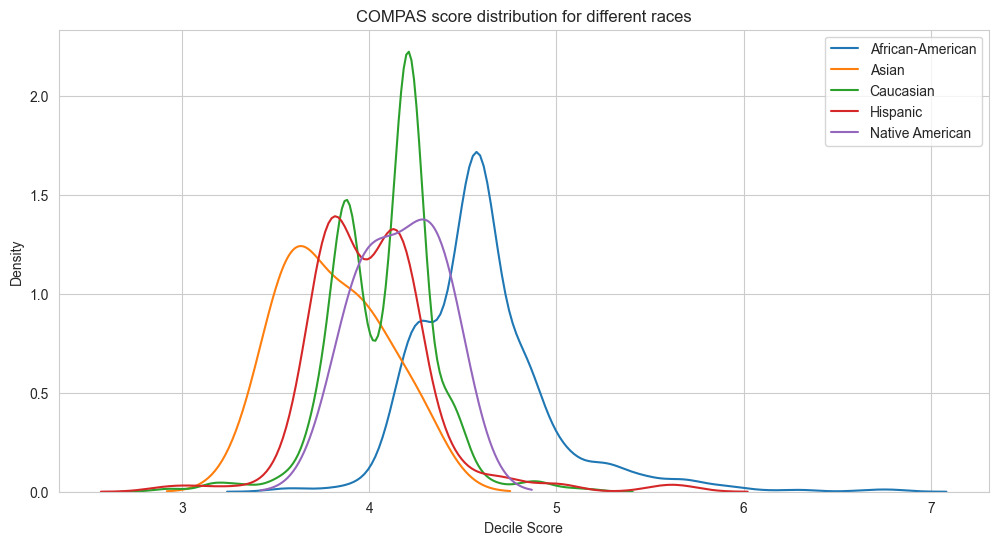

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# Custom Decision Tree Regressor (used as base estimator for Random Forest)
class DecisionTreeRegressor(BaseEstimator, RegressorMixin):
    """Custom decision tree implementation for regression tasks"""

    def __init__(self, max_depth=None, min_samples_split=2):
        # max_depth: controls tree complexity (None = grow until pure)
        # min_samples_split: minimum samples needed to split a node
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    class Node:
        """Tree node structure storing split conditions or leaf values"""
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature    # Feature index for splitting
            self.threshold = threshold  # Split threshold value
            self.left = left          # Left subtree (≤ threshold)
            self.right = right        # Right subtree (> threshold)
            self.value = value        # Prediction value (for leaves)

    def _mse(self, y):
        """Calculate mean squared error for a target vector"""
        return np.mean((y - np.mean(y))**2) if len(y) > 0 else float('inf')

    def _best_split(self, X, y):
        """Find optimal feature and threshold to minimize MSE"""
        best_mse, best_feature, best_threshold = float('inf'), None, None

        for feature in range(X.shape[1]):  # Test all features
            for threshold in np.unique(X[:, feature]):  # Test all unique values
                left_idx = X[:, feature] <= threshold
                total_mse = self._mse(y[left_idx]) + self._mse(y[~left_idx])
                if total_mse < best_mse:  # Keep track of best split
                    best_mse, best_feature, best_threshold = total_mse, feature, threshold
        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        """Recursively build decision tree"""
        # Stopping conditions:
        # 1. Reached max depth
        # 2. Not enough samples to split
        # 3. All target values are identical
        if (depth == self.max_depth or
                len(y) < self.min_samples_split or
                len(np.unique(y)) == 1):
            return self.Node(value=np.mean(y))  # Create leaf node

        feature, threshold = self._best_split(X, y)
        if feature is None:  # No improvement possible
            return self.Node(value=np.mean(y))

        # Recursively build left and right subtrees
        left_idx = X[:, feature] <= threshold
        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[~left_idx], y[~left_idx], depth + 1)

        return self.Node(feature, threshold, left, right)

    def fit(self, X, y):
        """Build tree from training data"""
        self.tree_ = self._build_tree(np.array(X), np.array(y))
        return self

    def _predict_sample(self, x, node):
        """Predict single sample by traversing tree"""
        if node.value is not None:  # Reached leaf node
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        return self._predict_sample(x, node.right)

    def predict(self, X):
        """Predict target values for input samples"""
        return np.array([self._predict_sample(x, self.tree_) for x in np.array(X)])


# Random Forest Regressor Implementation
class RandomForestRegressorCustom(BaseEstimator, RegressorMixin):
    """Custom random forest using bagging and feature randomness"""

    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features=None):
        # n_estimators: number of trees in forest
        # max_depth: max tree depth (None = unlimited)
        # min_samples_split: min samples to split node
        # max_features: features considered per split (None = sqrt(n_features))
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []  # Stores (tree, features) tuples

    def fit(self, X, y):
        """Build forest using bootstrap samples and feature subsets"""
        self.n_features_ = X.shape[1]
        if self.max_features is None:
            self.max_features = int(np.sqrt(self.n_features_))  # Default to sqrt

        for _ in range(self.n_estimators):
            # 1. Create bootstrap sample (with replacement)
            X_sample, y_sample = resample(X, y)

            # 2. Random feature subset selection
            features = np.random.choice(self.n_features_, self.max_features, replace=False)

            # 3. Grow tree on bootstrap sample with feature subset
            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                         min_samples_split=self.min_samples_split)
            tree.fit(X_sample[:, features], y_sample)

            # Store tree and its feature subset
            self.trees.append((tree, features))
        return self

    def predict(self, X):
        """Average predictions from all trees"""
        predictions = np.zeros((len(X), len(self.trees)))

        # Get predictions from each tree (using its feature subset)
        for i, (tree, features) in enumerate(self.trees):
            predictions[:, i] = tree.predict(X[:, features])

        return np.mean(predictions, axis=1)  # Ensemble prediction

# Load data
df = pd.read_csv("compas-scores.csv")
df = df[
    (df['days_b_screening_arrest'].between(-30, 30)) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'].isin(['M','F']))
    ].copy()

# Choose features and target
features = ["age", "priors_count", "juv_fel_count", "juv_misd_count", "c_charge_degree", "race", "sex"]
target = "decile_score"

# One-hot encoding
X = pd.get_dummies(df[features], columns=["race", "sex", "c_charge_degree"])
y = df[target]

def handle_missing_data(X, y):
    """Handle missing data"""
    # For numeral choose median value
    num_cols = X.select_dtypes(include=np.number).columns
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())

    # For categorical - mode
    cat_cols = X.select_dtypes(exclude=np.number).columns
    for col in cat_cols:
        X[col] = X[col].fillna(X[col].mode()[0])

    # For target - delete line
    if y.isna().mean() < 0.1:
        y = y.dropna()
        X = X.loc[y.index]
    else: # If too much to delete - just fill with median value
        y = y.fillna(y.median())

    return X, y

X, y = handle_missing_data(X, y)

# Check data after filter
print(f"Rows left: {len(X)}")
print(f"Misses in feature: {X.isna().sum().sum()}")
print(f"Misses in target: {y.isna().sum()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
rf = RandomForestRegressorCustom(
    n_estimators=500,
    max_depth=10,
    min_samples_split=15,
    max_features=4
)
rf.fit(X_train.values, y_train.values)

# Model evaluation
y_pred = rf.predict(X_test.values)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")

# Feature importance analysis
feature_importances = np.zeros(X.shape[1])
for tree, features in rf.trees:
    feature_importances[features] += 1

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances / len(rf.trees)
}).sort_values('Importance', ascending=False)

print("\nFeature importances:")
print(importances.to_string())

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'][:15], importances['Importance'][:15])
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.savefig('feature_importances.png', bbox_inches='tight')
plt.show()

# Bias analysis
def analyze_bias(model, X, y, sensitive_feature):
    groups = X[sensitive_feature].unique()
    results = []

    for group in groups:
        mask = X[sensitive_feature] == group
        preds = model.predict(X[mask].values)
        mae = mean_absolute_error(y[mask], preds)
        avg_score = np.mean(preds)
        results.append({
            'Group': group,
            'MAE': mae,
            'Avg Score': avg_score,
            'Count': sum(mask)
        })

    return pd.DataFrame(results)

# Races analysis
race_cols = [c for c in X.columns if c.startswith('race_')]
for race_col in race_cols:
    X_test[race_col] = X_test[race_col].astype(int)

bias_report = analyze_bias(rf, X_test, y_test, 'race_African-American')
print("\nBias analysis for races:")
print(bias_report)

# COMPAS score visualization
plt.figure(figsize=(12, 6))
for race_col in race_cols[:5]:  # First 5 race categories
    sns.kdeplot(y_pred[X_test[race_col] == 1], label=race_col.split('_')[-1])
plt.title("COMPAS score distribution for different races")
plt.xlabel("Decile Score")
plt.ylabel("Density")
plt.legend()
plt.savefig('scores_by_race.png', bbox_inches='tight')
plt.show()

# Save model and report
import pickle
with open('compas_rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

with open('model_report.txt', 'w') as f:
    f.write(f"""COMPAS Model Report
Model Performance:
- MAE: {mean_absolute_error(y_test, y_pred):.2f}

Top Features:
1. {importances.iloc[0]['Feature']}: {importances.iloc[0]['Importance']:.2f}
2. {importances.iloc[1]['Feature']}: {importances.iloc[1]['Importance']:.2f}
3. {importances.iloc[2]['Feature']}: {importances.iloc[2]['Importance']:.2f}

Bias Analysis:
{bias_report.to_string()}
""")

## FACE implementation

In [22]:
def generate_face(rf_model, x_orig, y_target, feature_names, immutable_features=[], lambda_=0.5, max_iter=1000):
    """
    Generate counterfactual explanation with constraints on immutable features
    for custom Random Forest model
    
    Parameters:
    - rf_model: trained RandomForestRegressorCustom instance
    - x_orig: original sample (pd.Series or dict)
    - y_target: target prediction value
    - feature_names: list of original feature names
    - immutable_features: list of features that cannot be changed
    - lambda_: learning rate
    - max_iter: maximum iterations
    
    Returns:
    - Counterfactual sample as numpy array
    """
    # Convert to DataFrame if needed
    if isinstance(x_orig, dict):
        x_orig = pd.Series(x_orig)

    # Create immutable mask
    immutable_mask = np.array([f in immutable_features for f in feature_names])

    # Initialize counterfactual
    x_cf = x_orig.copy().values.astype(float)

    for _ in range(max_iter):
        # Get current prediction
        y_pred = rf_model.predict(x_cf.reshape(1, -1))[0]

        # Check convergence
        if abs(y_pred - y_target) < 0.1:
            break

        # Calculate numerical gradient
        grad = np.zeros_like(x_cf)
        eps = 1e-3

        for i in range(len(x_cf)):
            if immutable_mask[i]:
                continue

            x_temp = x_cf.copy()
            x_temp[i] += eps
            y_temp = rf_model.predict(x_temp.reshape(1, -1))[0]
            grad[i] = (y_temp - y_pred) / eps

        # Update with projection
        x_cf -= lambda_ * grad
        x_cf[immutable_mask] = x_orig.values[immutable_mask].astype(float)

    return x_cf

## Example of FACE usage

Original sample:
age                         25
priors_count                 8
juv_fel_count                0
juv_misd_count               3
race_African-American        1
race_Asian                   0
race_Caucasian               0
race_Hispanic                0
race_Native American         0
race_Other                   0
sex_Female               False
sex_Male                  True
c_charge_degree_F        False
c_charge_degree_M         True
Name: 8582, dtype: object

Original prediction: 5.13

Features transformations:
priors_count: 8.00 → -77.40
juv_fel_count: 0.00 → -212.94
juv_misd_count: 3.00 → -35.62
race_Asian: 0.00 → 180.99
race_Caucasian: 0.00 → 35.69
race_Hispanic: 0.00 → 84.90
race_Native American: 0.00 → 0.77
race_Other: 0.00 → 210.99
sex_Female: 0.00 → 15.37
c_charge_degree_F: 0.00 → -58.55

New prediction: 3.36 (target: 2.13)


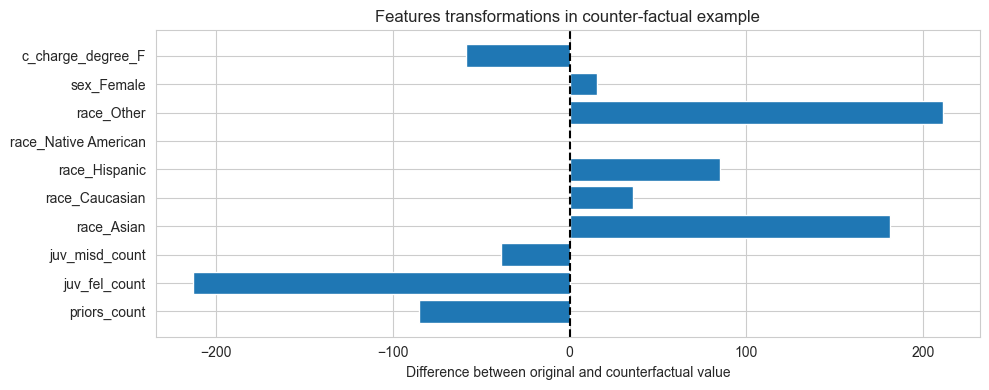

In [23]:
# Example of FACE usage
sample_idx = y_test[y_test > 7].index[0]
sample = X_test.loc[sample_idx]
print("Original sample:")
print(sample)

original_pred = rf.predict(sample.values.reshape(1, -1))[0]
print(f"\nOriginal prediction: {original_pred:.2f}")

# Generate example
target_value = max(original_pred - 3, 1)  # Target is to reduce COMPAS score by 3 unit
cf_vector = generate_face(
    rf,
    sample,
    target_value,
    X.columns.tolist(),
    immutable_features=['age', 'race_African-American']
)

# Transformations output
print("\nFeatures transformations:")
for i, (orig, cf) in enumerate(zip(sample.values, cf_vector)):
    if abs(orig - cf) > 0.01:  # Show only significant transformations
        print(f"{X.columns[i]}: {orig:.2f} → {cf:.2f}")

# Prediction for coutner-factual example
cf_pred = rf.predict(cf_vector.reshape(1, -1))[0]
print(f"\nNew prediction: {cf_pred:.2f} (target: {target_value:.2f})")

# Transformations visualizations
changes = pd.DataFrame({
    'Feature': X.columns,
    'Original': sample.values,
    'Counterfactual': cf_vector,
    'Difference': cf_vector - sample.values
}).query("abs(Difference) > 0.01")

plt.figure(figsize=(10, 4))
plt.barh(changes['Feature'], changes['Difference'])
plt.axvline(0, color='black', linestyle='--')
plt.title("Features transformations in counter-factual example")
plt.xlabel("Difference between original and counterfactual value")
plt.tight_layout()
plt.show()